#### Assign BA counts by County

The current version of assigning BA counts to a bus uses state-level population fractions, for example, if a BA is known to offer service in both WA and OR, e.g., BA=BPAT, then the BA counts, for example, are

BPATcount(WA) = BPATtotal * pop(WA)/(pop(WA) + pop(OR)
demandCount(WA) = sum(all fractional BA counts assigned to WA)

However, we actually know what counties each BA serves, so instead of using state-level population, we can use county level population. So 

* Demand in LoadZone = sumOverCountiesInLoadZone(demandPerCounty)
* demandPerCounty = sumOverBAs(BAcount(County))
* BAcounty(County) = BAtotal * CountyPopulation/sumOverCountyPopulationServedByBA

So we need to make a list of Counties per LoadZone and the corresponing populations for those Counties.
                   
<img src="BA-county_array.png">

Note that the array values have to be updated as county census data are updated anda as BA-county assignments change.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn; seaborn.set()
%matplotlib inline

import os
import sys
sys.path.append("..")

from westernintnet.westernintnet import win_data

Loading sub
Loading bus2sub
Loading bus
Loading genbus
Loading branches
Loading resources
Loading net_generation
Done loading


In [2]:
WA = ['AVA', 'BPAT','CHPD','DOPD','GCPD','PSEI','SCL','TPWR','AVA', 'BPAT']
OR = ['BPAT','GRID','IPCO','PACW','PGE']
CAnorth = ['BANC','CISO','PACW','BPAT']
CABayArea = ['CISO']
CAcentral = ['CISO', 'TIDC']
CAsw = ['CISO', 'LDWP']
CAse = ['CISO', 'IID']
NV = ['NEVP']
AZ = ['AZPS','DEAA','GRIF','GRMA','HGMA','PNM','SRP','TEPC','WALC']
UT = ['PACE']
NM = ['EPE','PNM']
CO = ['PSCO','WACM']
WY = ['PACE','WACM']
ID = ['AVA','BPAT','IPCO','PACE']
MT = ['BPAT','GWA','NWMT','WAUW','WWA'] 
ElPaso = ['EPE']

ba_all = sorted(list(set().union(WA,OR,CAnorth,CABayArea,CAcentral,CAsw,CAse,NV,AZ,UT,NM,CO,WY,ID,MT,ElPaso)))

In [3]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [4]:
if sys.platform == "darwin":
    basedir1= '/yourMaclocation/PreReise/prereise/gather/demanddata/EIA/'  #change to your Mac folder
elif sys.platform == "win32":
    basedir1 = 'U:\\src\\PreREISE\\prereise\\gather\\demanddata\\EIA\\'    #change to your Windows folder

In [5]:
dir_861 = basedir1 + 'test/data/'
dir_pop = basedir1 + 'test/data/'
dir_BA =  basedir1 + 'test/data/'

service_territory_file = 'Service_Territory_2016.xlsx'  #get utility-county mapping
ba_counts_file = 'Sales_Ult_Cust_2016.xlsx'  #Get utility-BAname mapping
ba_id_map_file = 'Balancing_Authority_2016.xlsx'  #use for checking final join: which BAs by state

#This assumes data has been through outlier fixing 
#ba_demand_file = 'BA_2016.csv'
ba_demand_file = 'BA_fixed_demand_threshold_3.csv'


#This file is edited from original due to mysterious read problems
us_counties_pop_file = 'USCountyPop.csv'

service_territory =  pd.read_excel(io = dir_861 + '/' + service_territory_file, 
                                   header = 0,
                                   dtype = {'Utility Number': str, 'County': str, 'State': str}
                                  )
ba_counts = pd.read_excel(io = dir_861 + '/' + ba_counts_file, 
                          header = 0, usecols = 'B,G,I,W', skiprows = [0,1], 
                          dtype = {'Utility Number': str, 'BA_CODE': str, 'State': str}
                          #sheet_name = ['States']
                         )
counties_pop = pd.read_csv(dir_pop + '/' + us_counties_pop_file, header=0)
ba_id_map = pd.read_excel(io = dir_861 + '/' + ba_id_map_file, header = 0)
ba_demand = pd.read_csv(dir_BA + '/' + ba_demand_file, header = 0, parse_dates = True, index_col = 'UTC Time')

ba_demand.fillna(0, inplace=True)

In [6]:
service_territory.head()

,Data Year,Utility Number,Utility Name,State,County
0,2016,34,City of Abbeville - (SC),SC,Abbeville
1,2016,55,City of Aberdeen - (MS),MS,Monroe
2,2016,59,City of Abbeville - (LA),LA,Vermilion
3,2016,84,A & N Electric Coop,MD,Somerset
4,2016,84,A & N Electric Coop,VA,Accomack


In [7]:
ba_counts.head()

,Utility Number,State,BA_CODE,Megawatthours
0,55,AL,TVA,0
1,55,MS,TVA,201106
2,59,LA,MISO,132078
3,84,MD,PJM,2565
4,84,VA,PJM,672045


In [8]:
ba_county = pd.merge(service_territory, ba_counts, how='outer', on ='Utility Number')

In [9]:
ba_county.head(10)

,Data Year,Utility Number,Utility Name,State_x,County,State_y,BA_CODE,Megawatthours
0,2016.0,34,City of Abbeville - (SC),SC,Abbeville,NaN,NaN,NaN
1,2016.0,55,City of Aberdeen - (MS),MS,Monroe,AL,TVA,0
2,2016.0,55,City of Aberdeen - (MS),MS,Monroe,MS,TVA,201106
3,2016.0,59,City of Abbeville - (LA),LA,Vermilion,LA,MISO,132078
4,2016.0,84,A & N Electric Coop,MD,Somerset,MD,PJM,2565
5,2016.0,84,A & N Electric Coop,MD,Somerset,VA,PJM,672045
6,2016.0,84,A & N Electric Coop,VA,Accomack,MD,PJM,2565
7,2016.0,84,A & N Electric Coop,VA,Accomack,VA,PJM,672045
8,2016.0,84,A & N Electric Coop,VA,Northampton,MD,PJM,2565
9,2016.0,84,A & N Electric Coop,VA,Northampton,VA,PJM,672045


In [10]:
ba_county.loc[ba_county['BA_CODE'].isin(ba_all)].sort_values('BA_CODE').head(20)

,Data Year,Utility Number,Utility Name,State_x,County,State_y,BA_CODE,Megawatthours
14165,2016.0,20169,Avista Corp,MT,Sanders,ID,AVA,2930223
14161,2016.0,20169,Avista Corp,ID,Nez Perce,WA,AVA,5578322
14162,2016.0,20169,Avista Corp,ID,Shoshone,ID,AVA,2930223
20943,NaN,99999,NaN,NaN,NaN,ID,AVA,78753
14163,2016.0,20169,Avista Corp,ID,Shoshone,MT,AVA,785
14164,2016.0,20169,Avista Corp,ID,Shoshone,WA,AVA,5578322
5792,2016.0,10454,Kootenai Electric Cooperative,ID,Kootenai,ID,AVA,419675
14166,2016.0,20169,Avista Corp,MT,Sanders,MT,AVA,785
14167,2016.0,20169,Avista Corp,MT,Sanders,WA,AVA,5578322
14168,2016.0,20169,Avista Corp,WA,Adams,ID,AVA,2930223


In [11]:
counties_pop.drop(columns = ['GEO.id', 'GEO.id2', 'rescen42010', 'resbase42010',
       'respop72010', 'respop72011', 'respop72012', 'respop72013',
       'respop72014', 'respop72015','respop72017'], inplace = True)

In [12]:
counties_pop.columns

Index(['GEO.display-label', 'respop72016'], dtype='object')

In [13]:
counties_pop.head()

,GEO.display-label,respop72016
0,"Autauga County, Alabama",55278
1,"Baldwin County, Alabama",207509
2,"Barbour County, Alabama",25774
3,"Bibb County, Alabama",22633
4,"Blount County, Alabama",57562


In [14]:
counties_pop['County'] = counties_pop['GEO.display-label'].str.split(',',expand=True)[0].str.replace(' County','')
counties_pop['State'] = counties_pop['GEO.display-label'].str.split(',',expand=True)[1].str.replace('^ ','')
counties_pop['State'] = counties_pop['State'].apply(lambda x: us_state_abbrev[x])
counties_pop.drop(columns = 'GEO.display-label', inplace = True)
counties_pop.rename(columns = {'respop72016':'pop2016'}, inplace=True)

In [15]:
counties_pop.head()

,pop2016,County,State
0,55278,Autauga,AL
1,207509,Baldwin,AL
2,25774,Barbour,AL
3,22633,Bibb,AL
4,57562,Blount,AL


In [16]:
ba_county.head()


,Data Year,Utility Number,Utility Name,State_x,County,State_y,BA_CODE,Megawatthours
0,2016.0,34,City of Abbeville - (SC),SC,Abbeville,NaN,NaN,NaN
1,2016.0,55,City of Aberdeen - (MS),MS,Monroe,AL,TVA,0
2,2016.0,55,City of Aberdeen - (MS),MS,Monroe,MS,TVA,201106
3,2016.0,59,City of Abbeville - (LA),LA,Vermilion,LA,MISO,132078
4,2016.0,84,A & N Electric Coop,MD,Somerset,MD,PJM,2565


In [17]:
ba_county_uniq = ba_county[['BA_CODE','County','State_x','State_y']].drop_duplicates(keep='first')
ba_county_uniq.drop(columns = ['State_y'], inplace=True)
ba_county_uniq.rename(columns = {'State_x':'State'}, inplace=True)
ba_county_uniq.dropna(axis = 0, how = 'any', inplace=True)
ba_county_uniq.drop_duplicates(keep = 'first', inplace=True)

In [18]:
ba_county_uniq.head()

,BA_CODE,County,State
1,TVA,Monroe,MS
3,MISO,Vermilion,LA
4,PJM,Somerset,MD
6,PJM,Accomack,VA
8,PJM,Northampton,VA


In [19]:
counties_pop.head()

,pop2016,County,State
0,55278,Autauga,AL
1,207509,Baldwin,AL
2,25774,Barbour,AL
3,22633,Bibb,AL
4,57562,Blount,AL


In [20]:
ba_counties_pop = pd.merge(ba_county_uniq, counties_pop, how = 'inner', on = ['County','State'])
ba_counties_pop['County_State'] = ba_counties_pop['County'] + ',' + ba_counties_pop['State']

In [21]:
ba_counties_pop.head()

,BA_CODE,County,State,pop2016,County_State
0,TVA,Monroe,MS,35908,"Monroe,MS"
1,PJM,Somerset,MD,25833,"Somerset,MD"
2,PJM,Accomack,VA,32818,"Accomack,VA"
3,PJM,Northampton,VA,12006,"Northampton,VA"
4,MISO,Adams,IL,66673,"Adams,IL"


In [22]:
ba_county_uniq['BA_CODE'].unique()

array(['TVA', 'MISO', 'PJM', 'NYIS', 'SOCO', 'SC', 'AZPS', 'FPC', 'CISO',
       'nan', 'DUK', 'SWPP', 'AMPL', 'AEC', 'LGEE', 'WALC', 'CPLE',
       'PACW', 'PSCO', 'AECI', 'ERCO', 'BPAT', 'NBSO', 'ISNE', 'WACM',
       'NWMT', 'PSEI', 'PACE', 'LDWP', 'PGE', 'SPA', 'SEC', 'PNM', 'CHPD',
       'AVA', 'CEA', 'NEVP', 'DOPD', 'EPE', 'EEI', 'FPL', 'JEA', 'FMPP',
       'SEPA', 'GVL', 'WAUW', 'HST', 'IPCO', 'IID', 'BANC', 'NSB', 'OVEC',
       'SCEG', 'GCPD', 'SRP', 'SCL', 'TPWR', 'TAL', 'TEC', 'TIDC', 'HECO',
       'TEPC'], dtype=object)

In [23]:
ba_counties_pop['BA_CODE'].unique()

array(['TVA', 'PJM', 'MISO', 'OVEC', 'NYIS', 'SOCO', 'SWPP', 'WALC',
       'WACM', 'PACW', 'SC', 'SCEG', 'DUK', 'AZPS', 'TEPC', 'AEC', 'FPC',
       'SEC', 'FPL', 'GVL', 'CISO', 'CPLE', 'AECI', 'LGEE', 'IID', 'PACE',
       'PNM', 'SRP', 'SPA', 'PSCO', 'ERCO', 'LDWP', 'EPE', 'BPAT', 'NBSO',
       'ISNE', 'FMPP', 'TEC', 'NWMT', 'WAUW', 'TPWR', 'GCPD', 'AVA',
       'PSEI', 'nan', 'NEVP', 'IPCO', 'PGE', 'CHPD', 'SCL', 'DOPD', 'JEA',
       'NSB', 'EEI', 'SEPA', 'TAL', 'BANC', 'TIDC', 'HECO'], dtype=object)

In [24]:
print(len(ba_county_uniq['BA_CODE'].unique()))
print(len(ba_counties_pop['BA_CODE'].unique()))

62
59


In [25]:
# Get WECC BAs

In [26]:
wecc_ba_counties_pop = ba_counties_pop.loc[ba_counties_pop['BA_CODE'].isin(ba_all)]

In [27]:
wecc_ba_counties_pop.shape

(1549, 5)

In [28]:
wecc_ba_counties_pop.loc[wecc_ba_counties_pop['State']=='NV'].sort_values('BA_CODE')


,BA_CODE,County,State,pop2016,County_State
3838,BPAT,Humboldt,NV,16873,"Humboldt,NV"
4284,BPAT,Elko,NV,52283,"Elko,NV"
4777,CISO,Washoe,NV,452429,"Washoe,NV"
4916,NEVP,Mineral,NV,4396,"Mineral,NV"
4915,NEVP,Lyon,NV,52854,"Lyon,NV"
4914,NEVP,Lander,NV,5765,"Lander,NV"
4913,NEVP,Esmeralda,NV,828,"Esmeralda,NV"
4912,NEVP,Douglas,NV,47947,"Douglas,NV"
4911,NEVP,Churchill,NV,24016,"Churchill,NV"
4910,NEVP,Carson City,NV,54283,"Carson City,NV"


In [29]:
wecc_ba_counties_pop.loc[wecc_ba_counties_pop['BA_CODE']=='IID']

,BA_CODE,County,State,pop2016,County_State
284,IID,Riverside,CA,2386522,"Riverside,CA"
3360,IID,Imperial,CA,180980,"Imperial,CA"
3366,IID,San Diego,CA,3317200,"San Diego,CA"


Some checks:
* Comparing with Balancing_Authority_2016.xlsx, BA='IID' is missing in NV list
* Comparing with Balancing_Authority_JAN17.pdf (which can arguably be lower resolution): only NEVP serves NV
* Document inconsistencies for later checking: which are real and which are due to the joins? (if any of BA, County, or State are missing, they drop off the list); How many counties are covered? For example, 'Fond du Lac, WI' is only present in county_pop file.

In [30]:
wecc_ba_counties_pop.loc[wecc_ba_counties_pop['State']=='UT']['BA_CODE'].unique()

array(['PACE', 'PACW', 'WACM', 'WALC', 'BPAT', 'NEVP'], dtype=object)

In [31]:
wecc_ba_counties_pop['BA_CODE'].unique()

array(['WALC', 'WACM', 'PACW', 'AZPS', 'TEPC', 'CISO', 'IID', 'PACE',
       'PNM', 'SRP', 'PSCO', 'LDWP', 'EPE', 'BPAT', 'NWMT', 'WAUW',
       'TPWR', 'GCPD', 'AVA', 'PSEI', 'NEVP', 'IPCO', 'PGE', 'CHPD',
       'SCL', 'DOPD', 'BANC', 'TIDC'], dtype=object)

In [32]:
len(wecc_ba_counties_pop['BA_CODE'].unique())

28

In [33]:
wecc_ba_counties_pop.loc[wecc_ba_counties_pop['BA_CODE']=='TEPC']

,BA_CODE,County,State,pop2016,County_State
69,TEPC,Pima,AZ,1012519,"Pima,AZ"
363,TEPC,Cochise,AZ,125355,"Cochise,AZ"
394,TEPC,Mohave,AZ,205385,"Mohave,AZ"
413,TEPC,Santa Cruz,AZ,46075,"Santa Cruz,AZ"


In [34]:
counties_pop.head()

,pop2016,County,State
0,55278,Autauga,AL
1,207509,Baldwin,AL
2,25774,Barbour,AL
3,22633,Bibb,AL
4,57562,Blount,AL


In [35]:
ba_counties_pop.loc[ba_counties_pop['BA_CODE']== 'EPE']['County'].tolist()

['Uvalde',
 'Eddy',
 'Otero',
 'Luna',
 'Sierra',
 'Culberson',
 'El Paso',
 'Hudspeth',
 'Dimmit',
 'Edwards',
 'Kinney',
 'Webb',
 'Zavala',
 'Brewster',
 'Crockett',
 'Jeff Davis',
 'Maverick',
 'Pecos',
 'Presidio',
 'Reeves',
 'Terrell',
 'Val Verde']

In [36]:
# Load Zone mapping: use county-pop file; except CA and ElPaso
wecc_states_list = ['WA','OR','CA','NV','AZ','UT','NM','CO','WY','ID','MT']

zone_county = {}
for r in wecc_states_list:
    zone_county[r] = counties_pop.loc[counties_pop['State'] == r]['County'].tolist()

zone_county['Northern_California'] = ['Butte','Colusa','Del Norte','El Dorado','Glenn','Humboldt',
                       'Lake','Lassen','Mendocino','Modoc','Nevada','Placer','Plumas',
                       'Sacramento','Shasta','Sierra','Siskiyou','Sutter','Tehama',
                       'Trinity','Yolo','Yuba']
zone_county['Bay_Area'] = ['Alameda','Contra Costa','Marin','Napa','San Francisco','San Mateo',
            'Santa Clara','Santa Cruz','Solano','Sonoma']
zone_county['Central_California'] = ['Alpine','Amador','Calaveras','Fresno','Inyo','Kings','Madera',
                      'Mariposa','Merced','Mono','Monterey','San Benito','San Joaquin',
                      'Stanislaus','Tulare','Tuolumne']
zone_county['Southeast_California'] = ['Imperial','Orange','Riverside','San Bernardino','San Diego']
zone_county['Southwest_California'] = ['Kern','Los Angeles','San Luis Obispo','Santa Barbara','Ventura']

#El Paso is defined by BA= EPE, so counties served by EPE
zone_county['El_Paso'] = ba_counties_pop.loc[ba_counties_pop['BA_CODE']== 'EPE']['County'].tolist()

* WA = ['AVA', 'BPAT','CHPD','DOPD','GCPD','PSEI','SCL','TPWR','AVA', 'BPAT']
* OR = ['BPAT','GRID','IPCO','PACW','PGE']
* CAnorth = ['BANC','CISO','PACW','BPAT']
* CABayArea = ['CISO']
* CAcentral = ['CISO', 'TIDC']
* CAsw = ['CISO', 'LDWP']
* CAse = ['CISO', 'IID']
* NV = ['NEVP']
* AZ = ['AZPS','DEAA','GRIF','GRMA','HGMA','PNM','SRP','TEPC','WALC']
* UT = ['PACE']
* NM = ['EPE','PNM']
* CO = ['PSCO','WACM']
* WY = ['PACE','WACM']
* ID = ['AVA','BPAT','IPCO','PACE']
* MT = ['BPAT','GWA','NWMT','WAUW','WWA'] 
* ElPaso = ['EPE']

In [37]:
wecc_ba_counties_pop.head()

,BA_CODE,County,State,pop2016,County_State
37,WALC,Stevens,MN,9747,"Stevens,MN"
38,WACM,Stevens,MN,9747,"Stevens,MN"
39,PACW,Stevens,MN,9747,"Stevens,MN"
41,WALC,Swift,MN,9444,"Swift,MN"
42,WACM,Swift,MN,9444,"Swift,MN"


In [38]:
BA_list = ba_counties_pop['BA_CODE'].unique()
ba_county_dict = {}

for ba in BA_list:
    ba_county_dict[ba] = ba_counties_pop.loc[ba_counties_pop['BA_CODE']==ba]['County_State']

In [39]:
ba_county_dict['EPE']

612         Uvalde,TX
1507          Eddy,NM
1511         Otero,NM
1948          Luna,NM
2472        Sierra,NM
2474     Culberson,TX
2476       El Paso,TX
2478      Hudspeth,TX
3952        Dimmit,TX
3955       Edwards,TX
3958        Kinney,TX
3960          Webb,TX
3963        Zavala,TX
4843      Brewster,TX
4845      Crockett,TX
4847    Jeff Davis,TX
4849      Maverick,TX
4851         Pecos,TX
4853      Presidio,TX
4855        Reeves,TX
4857       Terrell,TX
4859     Val Verde,TX
Name: County_State, dtype: object

In [40]:
ba_counties_pop.head()

,BA_CODE,County,State,pop2016,County_State
0,TVA,Monroe,MS,35908,"Monroe,MS"
1,PJM,Somerset,MD,25833,"Somerset,MD"
2,PJM,Accomack,VA,32818,"Accomack,VA"
3,PJM,Northampton,VA,12006,"Northampton,VA"
4,MISO,Adams,IL,66673,"Adams,IL"


In [41]:
ba_counties_pop['County'] + ',' + ba_counties_pop['State']

0             Monroe,MS
1           Somerset,MD
2           Accomack,VA
3        Northampton,VA
4              Adams,IL
5              Brown,IL
6           Schuyler,IL
7              Adams,WI
8           Columbia,WI
9               Dane,WI
10             Dodge,WI
11        Green Lake,WI
12         Jefferson,WI
13         Marquette,WI
14           Portage,WI
15              Sauk,WI
16           Waupaca,WI
17          Waushara,WI
18              Wood,WI
19             Adams,OH
20             Brown,OH
21          Highland,OH
22              Pike,OH
23              Pike,OH
24            Scioto,OH
25       Cattaraugus,NY
26              Erie,NY
27           Wyoming,NY
28              Cook,GA
29              Tift,GA
             ...       
5046            Ohio,WV
5047           Brown,WI
5048          Forest,WI
5049         Kenosha,WI
5050       Milwaukee,WI
5051          Racine,WI
5052        Langlade,WI
5053            Clay,TX
5054            Boyd,KY
5055           Perry,KY
5056            

In [42]:
ba_counties_pop.head()

,BA_CODE,County,State,pop2016,County_State
0,TVA,Monroe,MS,35908,"Monroe,MS"
1,PJM,Somerset,MD,25833,"Somerset,MD"
2,PJM,Accomack,VA,32818,"Accomack,VA"
3,PJM,Northampton,VA,12006,"Northampton,VA"
4,MISO,Adams,IL,66673,"Adams,IL"


In [43]:
ba_demand.head()

,AVA,AZPS,BANC,BPAT,CHPD,CISO,DEAA,DOPD,EPE,GCPD,...,PSEI,SCL,SRP,TEPC,TIDC,TPWR,WACM,WALC,WAUW,WWA
UTC Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,1789.0,2982.0,1909.0,7689.0,325.0,23745.0,0.0,256.0,848.0,540.0,...,4238.0,1411.0,2730.0,1624.0,245.0,732.0,3254.0,838.0,108.0,0.0
2016-01-01 01:00:00,1930.0,3363.0,2028.0,8143.0,353.0,24213.0,0.0,282.0,948.0,573.0,...,4712.0,1488.0,3026.0,1801.0,256.0,784.0,3472.0,904.0,123.0,0.0
2016-01-01 02:00:00,1991.0,3642.0,2271.0,8634.0,371.0,25174.0,0.0,298.0,988.0,592.0,...,5085.0,1588.0,3262.0,1788.0,284.0,839.0,3448.0,948.0,110.0,0.0
2016-01-01 03:00:00,1970.0,3615.0,2301.0,8598.0,366.0,28423.0,0.0,293.0,959.0,594.0,...,5030.0,1551.0,3220.0,1763.0,285.0,837.0,3417.0,937.0,115.0,0.0
2016-01-01 04:00:00,1905.0,3568.0,2242.0,8390.0,365.0,28784.0,0.0,294.0,929.0,593.0,...,4845.0,1484.0,3142.0,1739.0,276.0,816.0,3374.0,922.0,112.0,0.0


In [44]:
zone_county

{'WA': ['Adams',
  'Asotin',
  'Benton',
  'Chelan',
  'Clallam',
  'Clark',
  'Columbia',
  'Cowlitz',
  'Douglas',
  'Ferry',
  'Franklin',
  'Garfield',
  'Grant',
  'Grays Harbor',
  'Island',
  'Jefferson',
  'King',
  'Kitsap',
  'Kittitas',
  'Klickitat',
  'Lewis',
  'Lincoln',
  'Mason',
  'Okanogan',
  'Pacific',
  'Pend Oreille',
  'Pierce',
  'San Juan',
  'Skagit',
  'Skamania',
  'Snohomish',
  'Spokane',
  'Stevens',
  'Thurston',
  'Wahkiakum',
  'Walla Walla',
  'Whatcom',
  'Whitman',
  'Yakima'],
 'OR': ['Baker',
  'Benton',
  'Clackamas',
  'Clatsop',
  'Columbia',
  'Coos',
  'Crook',
  'Curry',
  'Deschutes',
  'Douglas',
  'Gilliam',
  'Grant',
  'Harney',
  'Hood River',
  'Jackson',
  'Jefferson',
  'Josephine',
  'Klamath',
  'Lake',
  'Lane',
  'Lincoln',
  'Linn',
  'Malheur',
  'Marion',
  'Morrow',
  'Multnomah',
  'Polk',
  'Sherman',
  'Tillamook',
  'Umatilla',
  'Union',
  'Wallowa',
  'Wasco',
  'Washington',
  'Wheeler',
  'Yamhill'],
 'CA': ['Alamed

In [45]:
zone_county.keys()

dict_keys(['WA', 'OR', 'CA', 'NV', 'AZ', 'UT', 'NM', 'CO', 'WY', 'ID', 'MT', 'Northern_California', 'Bay_Area', 'Central_California', 'Southeast_California', 'Southwest_California', 'El_Paso'])

In [46]:
def assign_BA_by_region_counties(bcp_df, ba_counts_df, region_county_dict):

    ba_df = ba_counts_df.copy()
    ba_list = ba_counts_df.columns
    
    
    for ba in ba_list:
        #Note only BAs in WECC will have ba_frac cols
        sum_counties_per_ba = bcp_df.loc[bcp_df['BA_CODE']==ba]['pop2016'].sum()
        #calc BA(t)/sum_counties_per_ba
        
        ba_df[ba + '_frac'] = ba_df[ba]/sum_counties_per_ba
        
    #Set NaNs to be zero for those BA's with no demand counts, which gives ba_frac value to be NaN
    ba_df.fillna(0, inplace=True)
    
    print(ba_df.columns)
    #now have extra cols in ba_counts_df
   
    county_ba_dict = {} #This dict is {'county_state':[list of BA's servicing county]}
    for county_state in bcp_df['County_State'].unique():
        county_ba_dict[county_state] = bcp_df.loc[bcp_df['County_State'] == county_state]['BA_CODE'].tolist() 
    
    
    #Sum over BAs per county: For now, we only  have WECC BA, so restrict these to counties served by WECC BAs
    county_count = 0
    for county_state in bcp_df['County_State'].unique():
        #do sum over BA in county_state
        
        county_count = county_count +1
        
        ba_df[county_state] = 0
        #for ba in county_ba_dict[county_state]:
        for ba in ba_list:
            #Only county_state served by ba's in ba_list will have non-zero values?
            
            result = bcp_df.loc[(bcp_df['BA_CODE']==ba) & (bcp_df['County_State']== county_state)]
            if len(result) == 0:
                pop = 0
            else:
                pop = bcp_df.loc[(bcp_df['BA_CODE']==ba) & (bcp_df['County_State']== county_state)].iloc[0]['pop2016']
            
            ba_df[county_state] = ba_df[county_state] + ba_df[ba + '_frac']*pop
            
    print('Done with county counting')
    print('ba_df size ', ba_df.shape)
    #Now have BA assigned per county_state, and a very large file: now assign to region
    region_list1 = ['WA','OR','Northern_California','Bay_Area','Central_California','Southwest_California',
                   'Southeast_California','NV','AZ','UT','NM','CO','WY','ID','MT','El_Paso'] 
    region_list0 = ['WA','OR','CA','CA','CA','CA','CA','NV','AZ','UT','NM','CO','WY','ID','MT','TX']
    
    for region in zip(region_list0,region_list1):
        ba_df[region[1]] = 0
        for county in region_county_dict[region[1]]:
            county_state = county + ',' + region[0]
            #print(county_state)
            if county_state in ba_df.columns:
                ba_df[region[1]] = ba_df[region[1]] + ba_df[county_state]
            else:
                continue
    
    print(ba_df.shape)
    
    #drop_these1 = bcp_df['County_State'].unique()
    drop_these2 = [col for col in ba_df.columns if col.find('_frac')>0]
    #ba_df.drop(columns = drop_these1, inplace = True)
    ba_df.drop(columns = drop_these2, inplace = True)
    
    return ba_df
    
        

In [47]:
#WI.load_zones
win_data.load_zones

{1: 'Washington',
 2: 'Oregon',
 3: 'Northern California',
 4: 'Bay Area',
 5: 'Central California',
 6: 'Southwest California',
 7: 'Southeast California',
 8: 'Nevada',
 9: 'Arizona',
 10: 'Utah',
 11: 'New Mexico',
 12: 'Colorado',
 13: 'Wyoming',
 14: 'Idaho',
 15: 'Montana',
 16: 'El Paso'}

In [48]:
wecc_ba_counties_pop = ba_counties_pop.loc[ba_counties_pop['BA_CODE'].isin(ba_demand.columns)]

In [49]:
final_df = assign_BA_by_region_counties(wecc_ba_counties_pop, ba_demand, zone_county)

Index(['AVA', 'AZPS', 'BANC', 'BPAT', 'CHPD', 'CISO', 'DEAA', 'DOPD', 'EPE',
       'GCPD', 'GRID', 'GRIF', 'GRMA', 'GWA', 'HGMA', 'IID', 'IPCO', 'LDWP',
       'NEVP', 'NWMT', 'PACE', 'PACW', 'PGE', 'PNM', 'PSCO', 'PSEI', 'SCL',
       'SRP', 'TEPC', 'TIDC', 'TPWR', 'WACM', 'WALC', 'WAUW', 'WWA',
       'AVA_frac', 'AZPS_frac', 'BANC_frac', 'BPAT_frac', 'CHPD_frac',
       'CISO_frac', 'DEAA_frac', 'DOPD_frac', 'EPE_frac', 'GCPD_frac',
       'GRID_frac', 'GRIF_frac', 'GRMA_frac', 'GWA_frac', 'HGMA_frac',
       'IID_frac', 'IPCO_frac', 'LDWP_frac', 'NEVP_frac', 'NWMT_frac',
       'PACE_frac', 'PACW_frac', 'PGE_frac', 'PNM_frac', 'PSCO_frac',
       'PSEI_frac', 'SCL_frac', 'SRP_frac', 'TEPC_frac', 'TIDC_frac',
       'TPWR_frac', 'WACM_frac', 'WALC_frac', 'WAUW_frac', 'WWA_frac'],
      dtype='object')
Done with county counting
ba_df size  (8784, 670)
(8784, 686)


Check some states

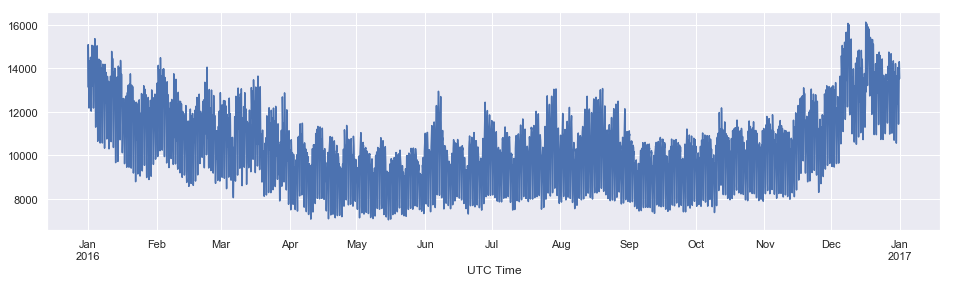

In [50]:
final_df['WA'].plot(figsize = [16,4])

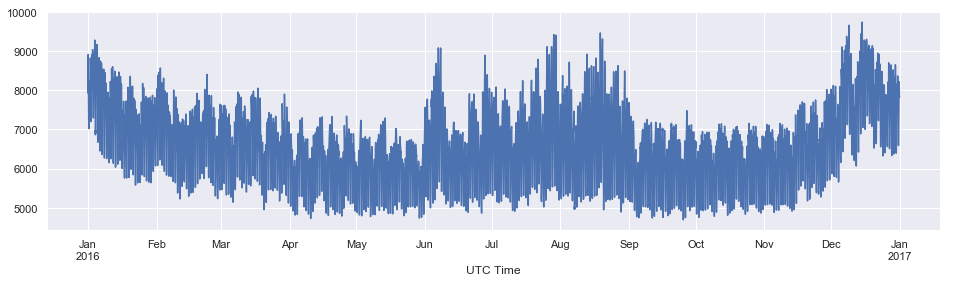

In [51]:
final_df['OR'].plot(figsize = [16,4])

In [52]:
win_data.read_demand_data()
demand_v2 = win_data.demand_data_2016

Load demand data


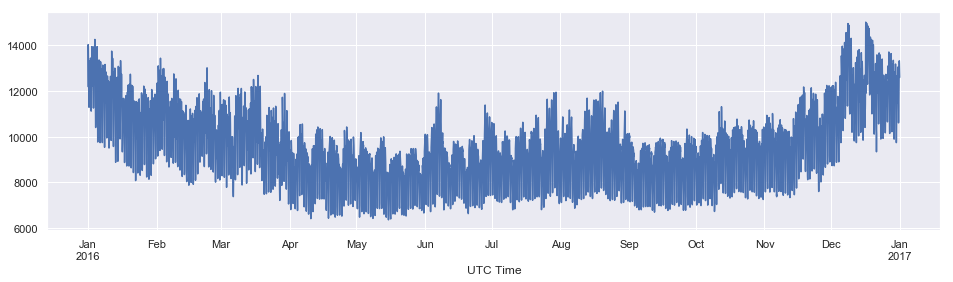

In [53]:
demand_v2['Washington'].plot(figsize=[16,4])

Compare previous state-based assignment method with county-based assignment method

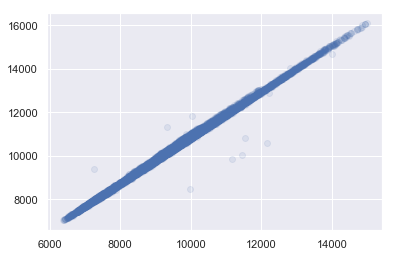

In [54]:
plt.scatter(demand_v2['Washington'], final_df['WA'], alpha=0.1)

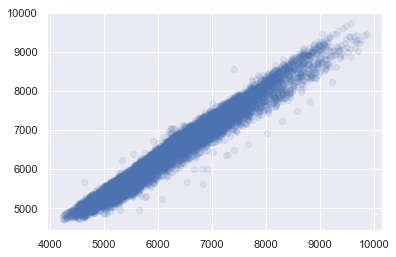

In [55]:
plt.scatter(demand_v2['Oregon'], final_df['OR'], alpha=0.1)

In [56]:
final_df.drop(columns = ba_demand.columns, inplace=True)
final_df.drop(columns = [col for col in final_df.columns if col.find(',')>0], inplace=True)

In [57]:
final_df.head()

,WA,OR,Northern_California,Bay_Area,Central_California,Southwest_California,Southeast_California,NV,AZ,UT,NM,CO,WY,ID,MT,El_Paso
UTC Time,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,13138.912133,7931.272718,4581.756302,5449.448081,3965.918300,10555.926843,7989.278249,4056.247137,9426.158568,2534.103646,1658.372105,6708.794441,496.456805,3257.385204,2016.655782,758.066951
2016-01-01 01:00:00,14196.128429,8424.215303,4794.128149,5589.061115,4111.185362,10830.337635,8212.393905,4354.862679,10440.773078,2735.707286,1840.977527,7305.715316,534.203336,3525.861816,2157.699159,847.461639
2016-01-01 02:00:00,15082.202594,8911.571165,5105.196144,5807.213483,4353.274565,11506.886265,8563.456938,4698.825256,11011.825237,2807.643502,1894.560512,7302.806917,545.308564,3658.207485,2184.240223,883.219514
2016-01-01 03:00:00,14920.258797,8719.531664,5395.370535,6456.008283,4686.633401,12567.699557,9479.417089,4743.868179,10879.628060,2673.491562,1860.462225,7096.438206,527.067132,3596.384574,2143.173289,857.295054
2016-01-01 04:00:00,14510.137138,8578.207176,5372.862689,6513.830394,4677.593622,12587.519675,9554.647468,4665.608571,10710.396212,2743.516026,1847.336200,6897.651631,530.552490,3535.226177,2091.952163,830.476648


In [58]:
final_df.shape

(8784, 16)

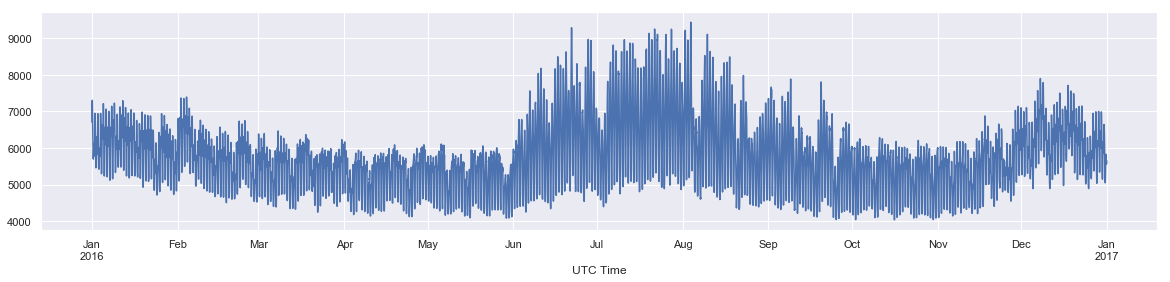

In [59]:
final_df['CO'].plot(figsize=[20,4])

In [60]:
final_df.describe()

,WA,OR,Northern_California,Bay_Area,Central_California,Southwest_California,Southeast_California,NV,AZ,UT,NM,CO,WY,ID,MT,El_Paso
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,10410.265544,6612.556582,4810.813511,5893.392378,4243.300444,11603.507891,8709.286132,4218.650508,10509.883941,2338.955096,1597.917537,5737.481243,442.248600,2866.464324,1689.526314,854.572048
std,1680.692249,974.276831,912.337539,1020.274003,791.066710,2210.781575,1587.027212,959.335319,2627.358073,319.775451,255.027293,949.832497,56.155051,530.967734,225.737970,228.653762
min,7038.457473,4689.031277,3431.200992,4213.397092,2893.504994,7839.504105,6150.849247,2920.775792,7121.934948,1356.657698,1175.372134,4032.963237,299.736998,1852.999776,1234.019235,0.000000
25%,9257.983961,5887.776059,4188.427924,5143.392153,3687.362831,9961.540542,7551.210506,3602.491259,8675.991806,2112.680935,1431.787801,5086.764303,401.177695,2510.954048,1527.596116,692.808829
50%,10304.631984,6618.884431,4629.536299,5750.267147,4104.314644,11341.706530,8454.122420,3923.128866,9697.363554,2307.465644,1545.313858,5628.543648,437.855327,2775.179897,1675.969784,796.506667
75%,11387.925579,7222.026419,5118.078673,6326.817629,4533.361064,12557.326355,9371.176905,4487.224618,11599.974832,2511.417069,1712.336133,6206.258390,476.954894,3161.490872,1829.779928,947.583689
max,16115.695560,9741.334200,8889.690155,10089.098275,7698.811143,20678.062458,15176.031182,8238.679852,19987.547470,3642.440683,2546.188983,9445.805323,636.558818,4743.748696,2447.851957,1697.605118


In [61]:
ba_v2 = win_data.demand_data_2016

In [62]:
ba_v2.describe()

,Washington,Oregon,Northern California,Bay Area,Central California,Southwest California,Southeast California,Nevada,Arizona,Utah,New Mexico,Colorado,Wyoming,Idaho,Montana,El Paso
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,9577.067048,6407.425583,4175.545203,5402.610679,2823.021380,10857.845790,8971.947644,4148.422017,10866.974780,3046.670310,1101.942407,7509.732247,858.078925,3085.334701,1714.448692,234.598524
std,1592.682555,1060.619217,744.725536,988.021095,537.207333,2075.996816,1718.706294,1047.604833,2762.067378,423.856077,248.005160,1153.927677,110.012318,438.177110,231.648549,62.896107
min,6369.823319,4232.133898,2811.187977,3770.489617,1856.739981,7134.659643,6188.059544,2747.000000,6686.043117,1555.057243,360.785579,2955.115286,548.521415,2107.599396,1109.196855,0.000000
25%,8483.752686,5637.972439,3640.034714,4677.935712,2430.893301,9315.370227,7714.786430,3470.000000,8876.949281,2751.740305,931.687555,6736.373566,783.362758,2774.177635,1548.958623,190.156270
50%,9460.716479,6372.330284,4109.776987,5258.986731,2732.295099,10614.484638,8691.959092,3798.000000,9999.592504,3001.742134,1043.411708,7343.662943,844.189369,3034.954118,1699.207803,218.618370
75%,10515.224211,7067.802431,4562.563568,5821.037407,3041.798631,11750.307856,9690.097719,4436.000000,12077.449569,3264.358733,1200.658183,8078.226149,916.317084,3349.052559,1858.426253,260.084704
max,14994.678833,9871.664208,7275.399896,9449.846091,5039.747740,19426.169495,15954.551173,8525.000000,20897.867919,7164.616611,2031.505399,14633.472104,1630.120602,5431.386540,2503.464584,465.944202


In [63]:
CAtotal1 = (final_df['Northern_California'].sum() + final_df['Bay_Area'].sum() 
           + final_df['Central_California'].sum() + final_df['Southwest_California'].sum() 
           + final_df['Southeast_California'].sum()) 

In [64]:
CAtotal1

309726478.32130575

In [65]:
CAtotal2 = (ba_v2['Northern California'].sum() + ba_v2['Bay Area'].sum() 
           + ba_v2['Central California'].sum() + ba_v2['Southwest California'].sum() 
           + ba_v2['Southeast California'].sum())

In [66]:
CAtotal2

283116846.59875315